 # Fine-tuning DistilBERT for Text Classification on Custom Dataset



 We are going to fine-tune DistilBERT to predict diagnosis labels based on symptoms.

 ## Table of Contents

 * [Setup and Install Libraries](#chapter_0)

 * [Explotary Data Analysis for Dataset](#chapter_1)

     * [Load Dataset](#section_1_1)

     * [Convert Label From Integer to String](#section_1_2)

     * [Class Distributions](#section_1_3)

     * [Handling Imbalance Data](#section_1_4)

     * [Length of Sentences](#section_1_5)

 * [Tokenization Process](#chapter_2)

     * [Tokenize a Sentence from Dataset](#section_2_1)

     * [Tokenizing the Whole Dataset](#section_2_2)

 * [Training the Text Classifier](#chapter_3)

     * [Evaluation Metrics](#section_3_0)

     * [Training Methodology: Fine-Tuning DistilBERT](#section_3_2)

         * [Define Training Arguments](#section_3_2_1)

         * [Fine-Tune 'distilbert/distilbert-base-german-cased' Model](#section_3_2_2)

             * [Training the Model](#section_3_2_2_1)

             * [Confusion Matrix on Test Set](#section_3_2_2_2)

             * [Error Analysis on Test Set](#section_3_2_2_3)

 * [Inference and Pushing Model to Hub](#chapter_4)

 ## Install and Import Libraries <a class="anchor"  id="chapter_0"></a>

In [1]:
import torch
# Check for MPS device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [2]:
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn.functional as F

from umap import UMAP
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

import datasets
from datasets import Dataset, DatasetDict, load_dataset

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer


/opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 ## Explotary Data Analysis for Dataset <a class="anchor"  id="chapter_1"></a>

 ### Load Dataset <a class="anchor"  id="section_1_1"></a>

In [3]:
# %%

df_train = pd.read_csv('../datasets/train.csv')
df_validation = pd.read_csv('../datasets/validation.csv')
df_test = pd.read_csv('../datasets/test.csv')


 ### Convert Label From Integer to String <a class="anchor"  id="section_1_2"></a>

In [4]:
# %%
label_encoder = LabelEncoder()
df_train['label'] = label_encoder.fit_transform(df_train['label'])
df_validation['label'] = label_encoder.transform(df_validation['label'])
df_test['label'] = label_encoder.transform(df_test['label'])


 ### Class Distributions <a class="anchor"  id="section_1_3"></a>

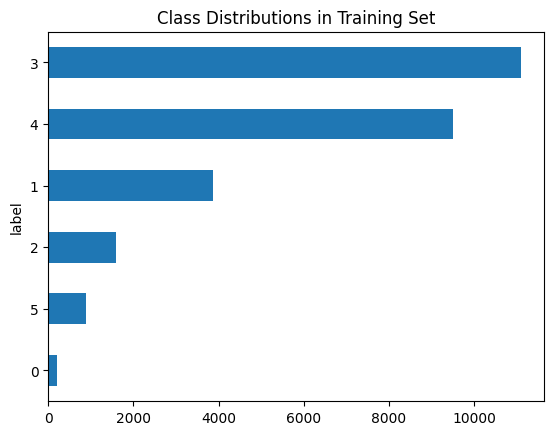

In [5]:
# %%
df_train['label'].value_counts(ascending=True).plot.barh()
plt.title("Class Distributions in Training Set")
plt.show()


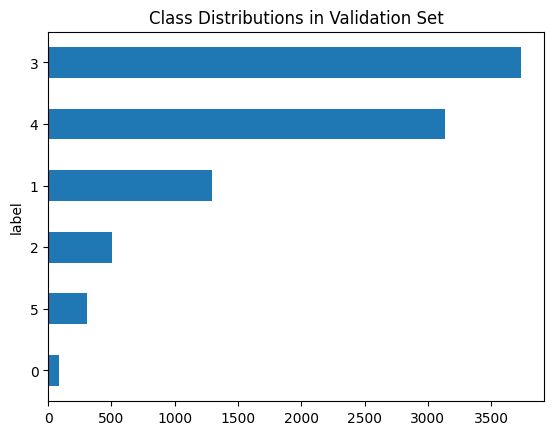

In [6]:
# %%
plt.title("Class Distributions in Validation Set")
df_validation['label'].value_counts(ascending=True).plot.barh()
plt.show()


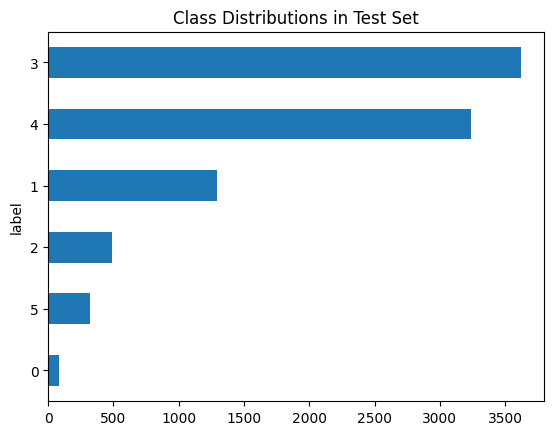

In [7]:
# %%
plt.title("Class Distributions in Test Set")
df_test['label'].value_counts(ascending=True).plot.barh()
plt.show()


 - There is imbalance distribution in dataset.

 ### Handling Imbalance Data <a class="anchor"  id="section_1_4"></a>

In [8]:
# %%
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(df_train[['sentence1']], df_train['label'])
df_train = pd.DataFrame({'sentence1': X_resampled['sentence1'], 'label': y_resampled})


 ### Length of Sentences <a class="anchor"  id="section_1_5"></a>

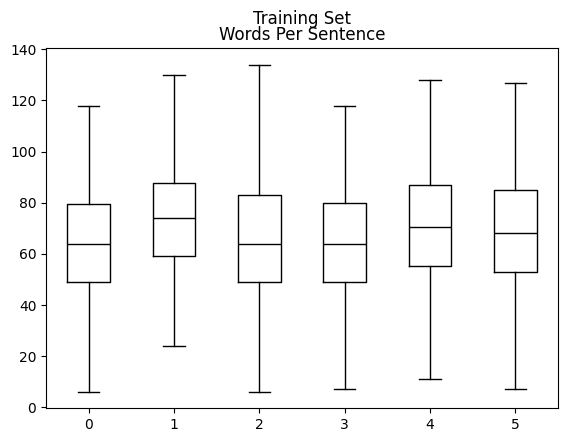

In [9]:
# %%
df_train["Words Per Sentence"] = df_train["sentence1"].str.split().apply(len)
df_train.boxplot("Words Per Sentence", by="label", grid=False, showfliers=False, color="black")
plt.suptitle("Training Set")
plt.xlabel("")
plt.show()
df_train.drop(columns=['Words Per Sentence'], inplace=True)


 ## Tokenization Process <a class="anchor"  id="chapter_2"></a>

 ### Tokenize a Sentence from Dataset <a class="anchor"  id="section_2_1"></a>

In [10]:
# %%
model_ckpt = "distilbert/distilbert-base-german-cased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


In [11]:
# # %%
# encoded_text = tokenizer("Die Symptome waren nicht gut.")
# print("encoded_text: ", encoded_text)
# tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
# print(encoded_text, len(encoded_text.input_ids))
# print(tokens)


 ### Tokenizing the Whole Dataset <a class="anchor"  id="section_2_2"></a>

In [12]:
# %%
def tokenize(batch):
    return tokenizer(batch["sentence1"], padding=True, truncation=True)


In [13]:
# %%
train_dataset = Dataset.from_pandas(df_train)
validation_dataset = Dataset.from_pandas(df_validation)
test_dataset = Dataset.from_pandas(df_test)


In [14]:
# %%
encoded_train_dataset = train_dataset.map(tokenize, batched=True, batch_size=None)
encoded_validation_dataset = validation_dataset.map(tokenize, batched=True, batch_size=None)
encoded_test_dataset = test_dataset.map(tokenize, batched=True, batch_size=None)


Map: 100%|██████████| 9052/9052 [00:01<00:00, 7653.15 examples/s]


 ## Training the Text Classifier <a class="anchor"  id="chapter_3"></a>

 ### Evaluation Metrics <a class="anchor"  id="chapter_3_0"></a>

In [15]:
# %%
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


 #### Define Training Arguments <a class="anchor"  id="section_3_2_1"></a>

In [16]:
# %%
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    use_mps_device=torch.backends.mps.is_available(),  # Updated to check for MPS availability
)



/opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.12/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.12/site-packages/transformers/training_args.py:2127: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(


 #### Fine-Tuning for 'distilbert/distilbert-base-german-cased' Model <a class="anchor"  id="section_3_2_2"></a>

 ##### Training the Model <a class="anchor"  id="section_3_2_2_1"></a>

In [17]:
# %%
# Define model
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=len(label_encoder.classes_)).to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# %%
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_validation_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


In [19]:
# %%
trainer.train()


  0%|          | 0/246 [00:00<?, ?it/s]

RuntimeError: Placeholder storage has not been allocated on MPS device!

 ##### Confusion Matrix on Test Set <a class="anchor"  id="section_3_2_2_2"></a>

In [ ]:
# %%
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()


In [ ]:
# %%
preds_output = trainer.predict(encoded_test_dataset)
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, encoded_test_dataset['label'], label_encoder.classes_)


 ##### Error Analysis on Test Set <a class="anchor"  id="section_3_2_2_3"></a>

In [ ]:
# %%
df_test = pd.DataFrame(encoded_test_dataset)
df_test['predicted_label'] = y_preds
df_test['label'] = label_encoder.inverse_transform(df_test['label'])
df_test['predicted_label'] = label_encoder.inverse_transform(df_test['predicted_label'])


In [ ]:
# %%
df_test.sort_values("loss", ascending=False).head(10)


 ## Inference and Pushing Model to Hub <a class="anchor"  id="chapter_4"></a>

In [ ]:
# %%
from transformers import pipeline
classifier = pipeline("text-classification", model=model_ckpt, tokenizer=tokenizer)
custom_sentence = "Ich habe heute einen Film gesehen und er war wirklich gut."
preds = classifier(custom_sentence, return_all_scores=True)


In [ ]:
# %%
preds_df = pd.DataFrame(preds[0])
plt.bar(label_encoder.classes_, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_sentence}"')
plt.ylabel("Class probability (%)")
plt.show()
